<a href="https://colab.research.google.com/github/zeligism/ScaledVR/blob/main/Scaled_VR_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sklearn
import scipy
import time
from numba import njit
from sklearn.preprocessing import normalize
SEED = 123
np.random.seed(SEED)

# Load data
data source: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

In [2]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a

--2022-01-20 21:10:45--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114818 (112K)
Saving to: ‘a1a’

a1a                 100%[===================>] 112.13K   146KB/s    in 0.8s    

2022-01-20 21:10:48 (146 KB/s) - ‘a1a’ saved [114818/114818]



In [3]:
!head a1a

-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 3:1 6:1 17:1 27:1 35:1 40:1 57:1 63:1 69:1 73:1 74:1 76:1 81:1 103:1 
-1 4:1 6:1 15:1 21:1 35:1 40:1 57:1 63:1 67:1 73:1 74:1 77:1 80:1 83:1 
-1 5:1 6:1 15:1 22:1 36:1 41:1 47:1 66:1 67:1 72:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 16:1 22:1 36:1 40:1 54:1 63:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 2:1 6:1 14:1 20:1 37:1 41:1 47:1 64:1 67:1 73:1 74:1 76:1 82:1 83:1 
-1 1:1 6:1 14:1 22:1 36:1 42:1 49:1 64:1 67:1 72:1 74:1 77:1 80:1 83:1 
-1 1:1 6:1 17:1 19:1 39:1 42:1 53:1 64:1 67:1 73:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 18:1 20:1 37:1 42:1 48:1 64:1 71:1 73:1 74:1 76:1 81:1 83:1 
+1 5:1 11:1 15:1 32:1 39:1 40:1 52:1 63:1 67:1 73:1 74:1 76:1 78:1 83:1 


In [4]:
# see  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

@mem.cache
def get_data(filePath):
    data = load_svmlight_file(filePath)
    return data[0], data[1]

X, y = get_data("a1a")
n, d =X.shape
X = normalize(X, norm='l2', axis=1)
print("We have %d samples, each has up to %d features"%(n,d))

________________________________________________________________________________
[Memory] Calling __main__--content-<ipython-input-c47fa7ee0e78>.get_data...
get_data('a1a')
_________________________________________________________get_data - 0.0s, 0.0min
We have 1605 samples, each has up to 119 features


# Logistic Loss
$n=$ number of data points

$d=$ feature dimension

$X \in \mathbb{R}^{n \times d}$, $x_i = X[i,:] \in \mathbb{R}^{d}$, $y \in \mathbb{R}^{n}$, and $w \in \mathbb{R}^{d}$.

Then,

$
F(w) = \frac1n \sum_{i=1}^n \log(1+e^{-y_i x_i^T w})
$

$
\nabla F(w) = \frac1n \sum_{i=1}^n 
\frac{\exp(-y_i x_i^T w)}{(1+\exp(-y_i x_i^T w))} (-y_i x_i)
$

$
\nabla^2 F(w) = \frac1n \sum_{i=1}^n 
\left(
  \frac{\exp(-y_i x_i^T w)}
       {(1+\exp(-y_i x_i^T w))^2}
\right) (  x_i x_i^T )
$

In [5]:
@njit
def logistic_loss_jit(X,y,w):
  ...

@njit
def logistic_loss_grad_jit(X,y,w):
  ...

def logistic_loss(X,y,w):
  t = -y * (X @ w)
  # large enough x approximates log(1+e^x) very well
  # e.g. when x > 23, log(1+e^x) - x < 1e-10
  loss = t*0.0
  loss[t > 20] = t[t > 20]
  loss[t <= 20] = np.log(1 + np.exp(t[t <= 20]))
  return np.mean(loss)

def logistic_loss_grad(X,y,w):
  t = -y * (X @ w)
  r = t*0.0
  ep = np.exp(t[t < 0])
  en = np.exp(-t[t >= 0])
  r[t <  0] = ep / (1 + ep)
  r[t >= 0] = 1 / (1 + en)
  grad = X.T.dot(-y * r) / X.shape[0]
  return grad

def logistic_loss_hessian(X,y,w):
  t = -y * (X @ w)
  r = t*0.0
  ep = np.exp(t[t < 0])
  en = np.exp(-t[t >= 0])
  r[t <  0] = ep / (1 + ep)**2
  r[t >= 0] = en / (1 + en)**2
  hessian = X.T.dot(r.reshape(-1,1) * X) / X.shape[0]
  return hessian

def logistic_loss_hvp(X,y,w,v):
  t = -y * (X @ w)
  r = t*0.0
  ep = np.exp(t[t < 0])
  en = np.exp(-t[t >= 0])
  r[t <  0] = ep / (1 + ep)**2
  r[t >= 0] = en / (1 + en)**2
  # HVP
  # r_n x_nd1 x_nd2 v_d2 = H_d1d2 v_d2 = hvp_d1
  hvp = np.einsum("n,ni,nj,j->i",r,X,X,v) / X.shape[0]
  return hvp


def F(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  return logistic_loss(X,y,w)

def grad(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  return logistic_loss_grad(X,y,w)

def hessian(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  X = np.array(X.todense()) # for element-wise prod
  return logistic_loss_hessian(X,y,w)

def hvp(X, y, w, v, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  X = np.array(X.todense()) # for element-wise prod
  return logistic_loss_hvp(X,y,w,v)


In [6]:
def test_logistic(X,y,w):
  import torch
  # np
  i = np.random.choice(X.shape[0], 10)
  X = X[i]
  y = y[i]
  L = F(X,y,w)
  G = grad(X,y,w)
  H = hessian(X,y,w)
  v = 10*np.random.rand(X.shape[1])
  Hvp = hvp(X,y,w,v)
  # torch
  def F_torch(w):
    return torch.mean(torch.log(1 + torch.exp(-y * (X @ w))))
  w = torch.Tensor(w).requires_grad_()
  X = torch.Tensor(X.todense()).requires_grad_()
  y = torch.Tensor(y)
  v = torch.Tensor(v)
  L_torch = F_torch(w)
  G_torch, = torch.autograd.grad(L_torch, w)
  H_torch = torch.autograd.functional.hessian(F_torch, w)
  Hvp_torch = torch.autograd.functional.hvp(F_torch, w, v)[1]
  # check
  print(L.sum(), "≈", L_torch.sum().item())
  assert np.abs(L.sum() - L_torch.sum().item()) < 1e-4
  print(G.sum(), "≈", G_torch.sum().item())
  assert np.abs(G.sum() - G_torch.sum().item()) < 1e-4
  print(H.sum(), "≈", H_torch.sum().item())
  assert np.abs(H.sum() - H_torch.sum().item()) < 1e-4
  print(Hvp.sum(), "≈", Hvp_torch.sum().item())
  assert np.abs(Hvp.sum() - Hvp_torch.sum().item()) < 1e-4

test_logistic(X,y,np.random.randn(X.shape[1]))
test_logistic(X,y,np.random.rand(X.shape[1])*10)
print("Success!")

1.1888641843282712 ≈ 1.1888641119003296
2.0731552636868997 ≈ 2.073155164718628
2.8533353344420793 ≈ 2.85333514213562
12.650845630421072 ≈ 12.650845527648926
12.546371206628981 ≈ 12.546370506286621
2.619159849121392 ≈ 2.6191599369049072
1.203392852223312e-06 ≈ 8.158598348018131e-07
5.580682746341652e-06 ≈ 3.7742129279649816e-06
Success!


# Plot

In [7]:
def plot_data(data, fname=None):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  fig.set_size_inches(20, 6)
  
  ax1.plot(data[:,0])
  ax1.set_ylabel(r"$F(w_t)$")
  ax1.set_xlabel(r"iteration $t$")  
  
  ax2.semilogy(data[:,1])
  ax2.set_ylabel(r"$||\nabla F(w_t)||^2$")
  ax2.set_xlabel(r"iteration $t$") 
  
  ax3.plot(data[:,2])
  ax3.set_ylabel(r"error")
  ax3.set_xlabel(r"iteration $t$") 

  if fname is not None:
    plt.savefig(fname)

# Optimization on badly-scaled data

## SGD

In [8]:
def SGD(X, y, gamma=0.02, BS=1, T=10000, seed=SEED):
  np.random.seed(seed+1)
  data = []
  w = np.zeros(X.shape[1])
  for it in range(T):
    i = np.random.choice(X.shape[0], BS)
    w = w - gamma * grad(X,y,w,i)
    data.append((F(X,y,w),
                  np.linalg.norm(grad(X,y,w))**2,
                  np.mean(X.dot(w)*y < 0)))
  return w, np.array(data)

CPU times: user 6.76 s, sys: 0 ns, total: 6.76 s
Wall time: 6.76 s


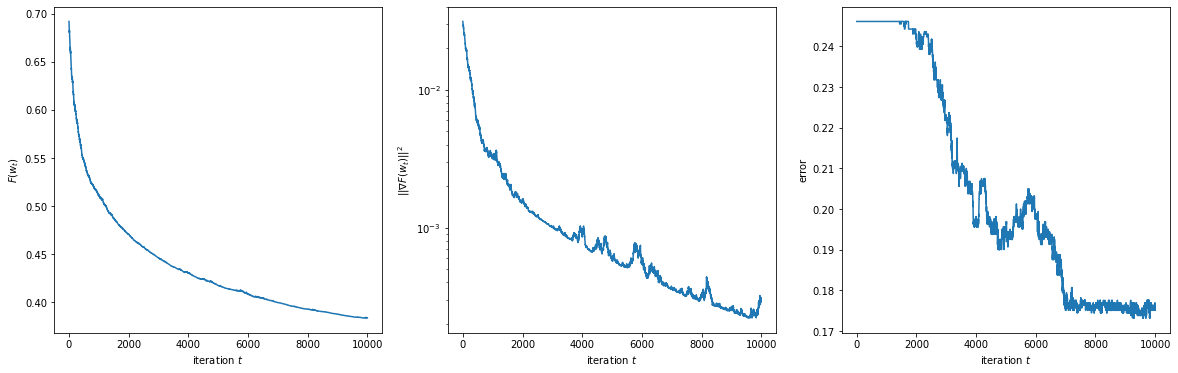

In [9]:
%%time
_, data = SGD(X,y)
plot_data(data)

using a bigger batch size
CPU times: user 6.79 s, sys: 10.5 ms, total: 6.8 s
Wall time: 6.8 s


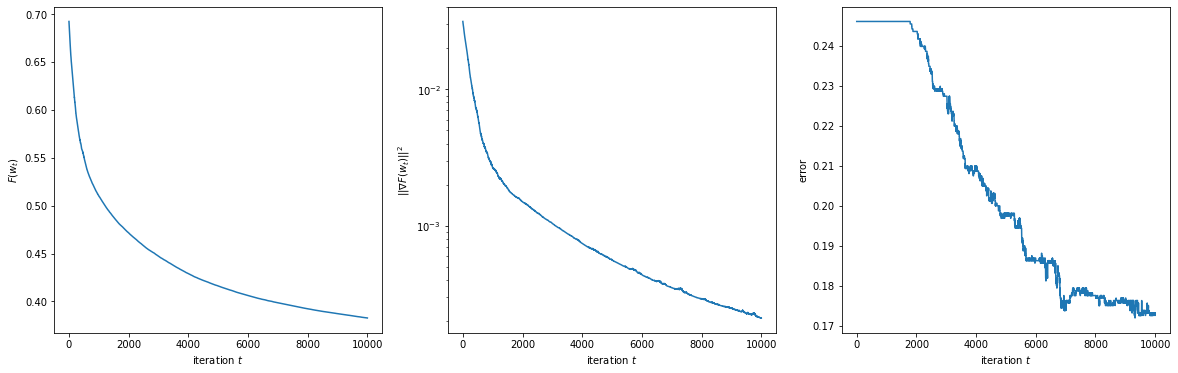

In [10]:
%%time
print("using a bigger batch size")
_, data = SGD(X,y,BS=10)
plot_data(data)

### Use bad scaling and run SGD again

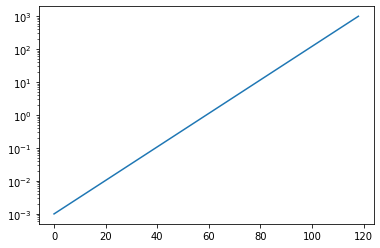

In [11]:
BAD_SCALE = 10**np.linspace(-3,3,X.shape[1])
#BAD_SCALE = 10**np.linspace(-3,5,X.shape[1])**3
plt.semilogy(BAD_SCALE)

def corrupt_scale(X, bad_scale=BAD_SCALE, seed=SEED):
  np.random.seed(seed+1)
  np.random.shuffle(bad_scale)
  X_bad = X[:]
  X_bad = X.multiply(bad_scale.reshape(1,-1)).tocsr()
  # X_bad = normalize(X_bad, norm='l2', axis=1)
  return X_bad

X_bad = corrupt_scale(X)

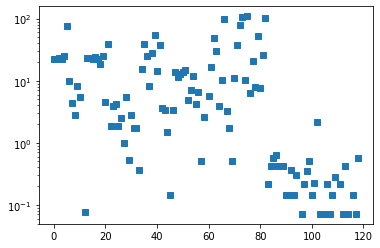

In [12]:
plt.semilogy([np.linalg.norm(X[:,j].data)**2 for j in range(d)],'s')

use uneven scaling of features
CPU times: user 6.72 s, sys: 14 ms, total: 6.74 s
Wall time: 6.74 s


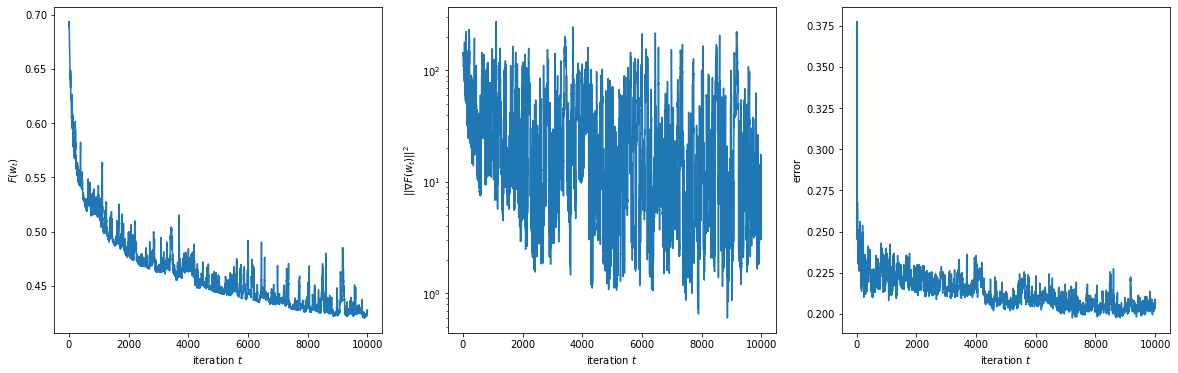

In [13]:
%%time
print("use uneven scaling of features")
_, data = SGD(X_bad,y,gamma=1e-5)
plot_data(data)

try with a bigger batch size
CPU times: user 6.82 s, sys: 21.4 ms, total: 6.84 s
Wall time: 6.83 s


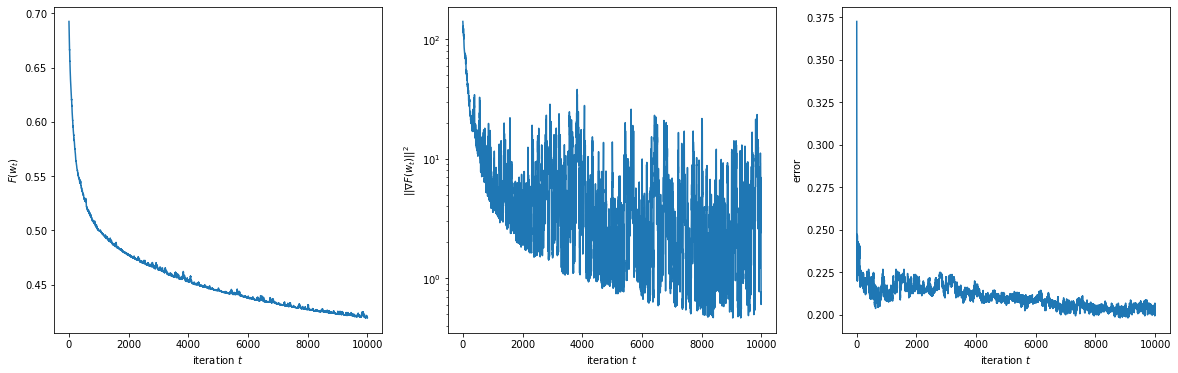

In [14]:
%%time
print("try with a bigger batch size")
_, data = SGD(X_bad,y,BS=10,gamma=1e-5)
plot_data(data)

## SARAH

In [15]:
def SARAH(X, y, gamma=0.2, BS=1, epochs=10, seed=SEED):
  np.random.seed(seed+1)
  data = []
  wn = np.zeros(X.shape[1])
  for ep in range(epochs):
    v = grad(X,y,wn)
    nv0 = np.linalg.norm(v)
    wp = wn[:]
    for it in range(10**10):
      i = np.random.choice(X.shape[0], BS)
      gn = grad(X,y,wn,i)
      gp = grad(X,y,wp,i)
      v += gn - gp
      wp = wn[:]
      wn = wn - gamma * v
      data.append((F(X,y,wn),
                   np.linalg.norm(grad(X,y,wn))**2,
                   np.mean(X.dot(wn)*y < 0)))
      nv = np.linalg.norm(v)
      if nv < 0.1*nv0 or it > X.shape[0]:
        break
        
  return wn, np.array(data)

CPU times: user 14.1 s, sys: 41.3 ms, total: 14.1 s
Wall time: 14.1 s


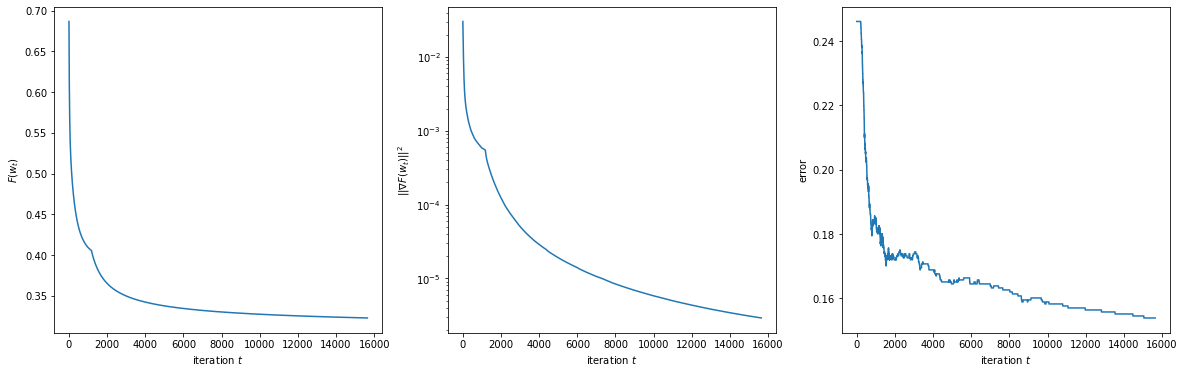

In [16]:
%%time
_, data = SARAH(X,y)
plot_data(data)

with a bigger batch size
CPU times: user 13.8 s, sys: 54.9 ms, total: 13.9 s
Wall time: 13.9 s


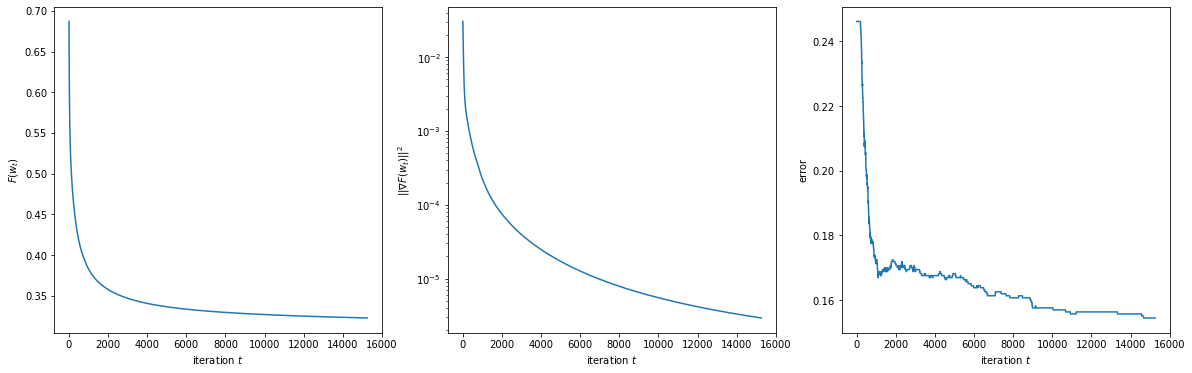

In [17]:
%%time
print("with a bigger batch size")
_, data = SARAH(X,y,BS=10)
plot_data(data)

### Use bad scaling and run SARAH again

use uneven scaling of features
CPU times: user 28.8 s, sys: 72 ms, total: 28.9 s
Wall time: 28.9 s


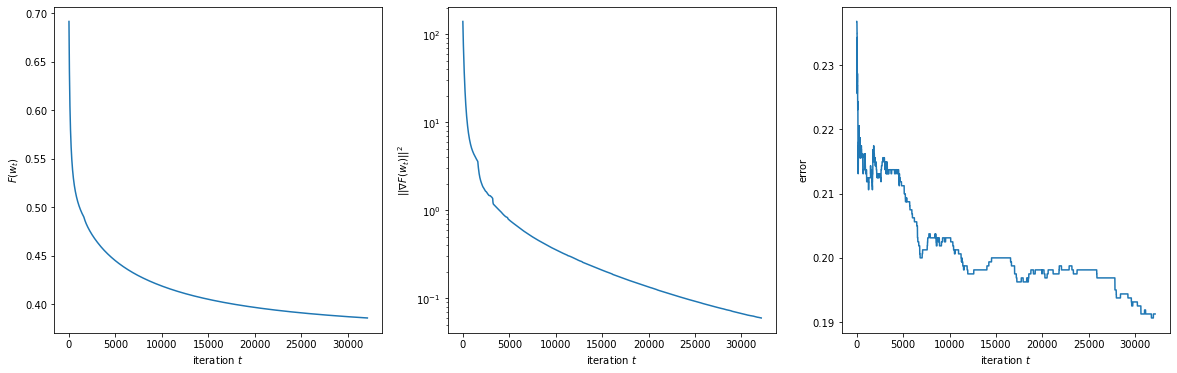

In [18]:
%%time
print("use uneven scaling of features")
_, data = SARAH(X_bad,y,gamma=1e-5,epochs=20)
plot_data(data)

with a bigger batch size
CPU times: user 29.2 s, sys: 69 ms, total: 29.2 s
Wall time: 29.2 s


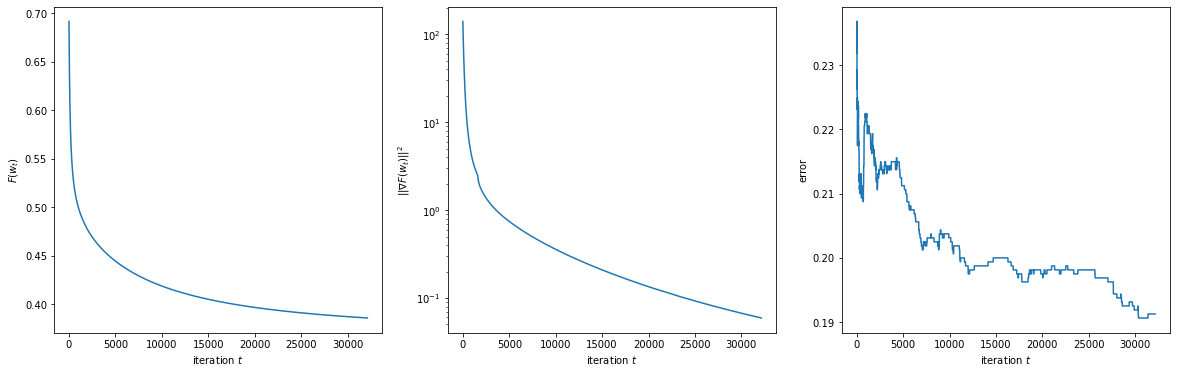

In [19]:
%%time
print("with a bigger batch size")
_, data = SARAH(X_bad,y,BS=10,gamma=1e-5,epochs=20)
plot_data(data)

# Hessian scaling

## Check approximation of Hessian diagonal

In [20]:
w = np.random.randn(X.shape[1])
H = hessian(X,y,w)
diag_H = np.diagonal(H)
H_bad = hessian(X_bad,y,w)
diag_H_bad = np.diagonal(H_bad)

0.20598513937002777
0.1789464670918542


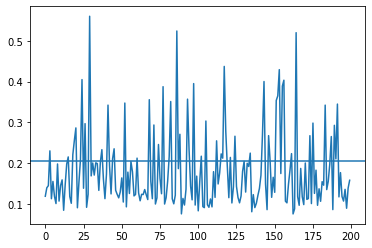

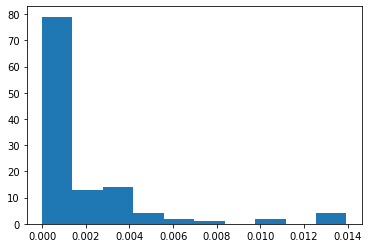

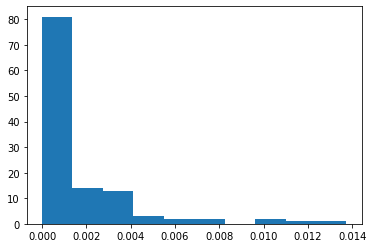

In [21]:
def sample_z():
  return 2*np.random.randint(0,2,(diag_H.shape[0]))-1

num_samples = 200
diag_H_approx = 0.
diag_H_sums = []
for _ in range(num_samples):
  z = sample_z()
  # grad(w+z)-grad(w) approx= H(w)z
  diag_H_i = z * (grad(X,y,w+z) - grad(X,y,w))
  diag_H_approx += diag_H_i / num_samples
  diag_H_sums.append(diag_H_i.sum())

plt.figure()
plt.plot(np.array(diag_H_sums))
plt.axhline(diag_H.sum())

plt.figure()
plt.hist(diag_H)
print(diag_H.sum())

plt.figure()
plt.hist(diag_H_approx)
print(diag_H_approx.sum())

## Run SARAH on badly-scaled data given the $diag(H)$ approximation

In [22]:
XTX = np.array((X.T @ X).todense())
XTX_bad = np.array((X_bad.T @ X_bad).todense())

PLotting singular values of X and X_bad


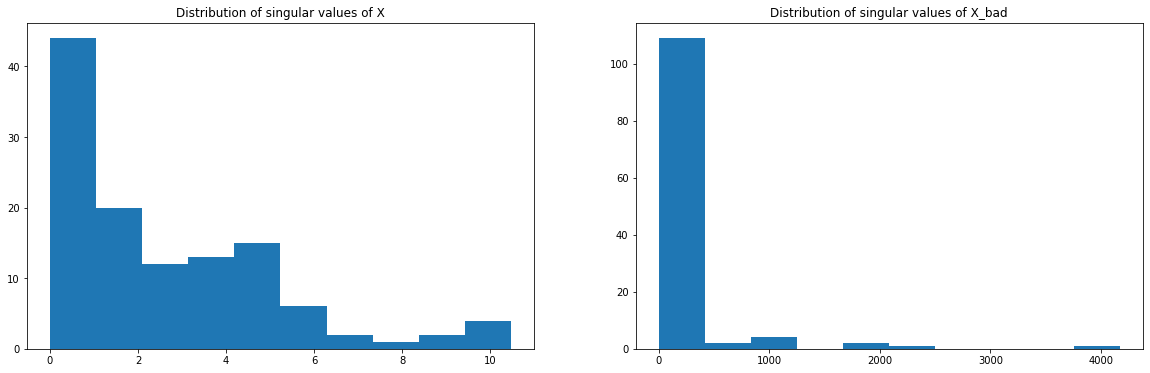

In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(20, 6)
ax1.set_title(r"Distribution of singular values of X")
ax1.hist(np.diagonal(XTX)**0.5)
ax2.set_title(r"Distribution of singular values of X_bad")
ax2.hist(np.diagonal(XTX_bad)**0.5)
print("PLotting singular values of X and X_bad")

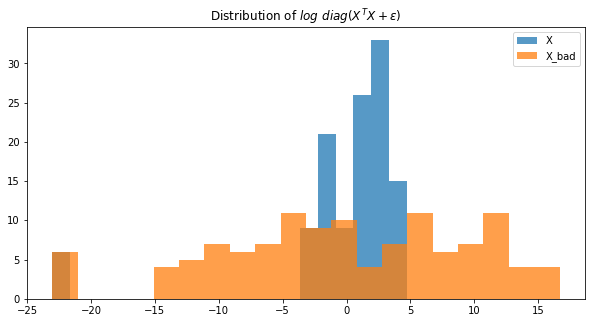

In [24]:
fig = plt.figure(figsize=(10,5))
plt.title(r"Distribution of $log\ diag(X^TX+\epsilon)$")
plt.hist(np.log(np.diagonal(1e-10+XTX)), label="X", bins=20, alpha=0.75)
plt.hist(np.log(np.diagonal(1e-10+XTX_bad)), label="X_bad", bins=20, alpha=0.75)
plt.legend()

### SGD

Run SGD on corrupted data
CPU times: user 6.8 s, sys: 14.9 ms, total: 6.82 s
Wall time: 6.82 s


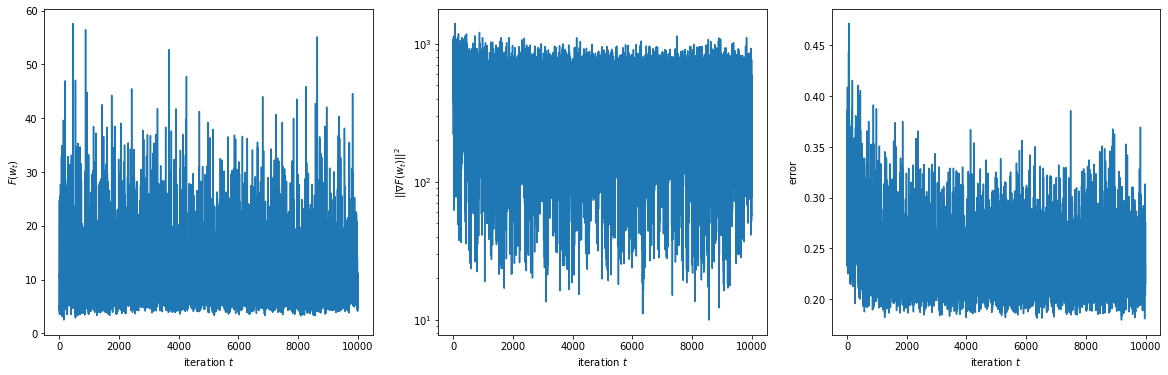

In [25]:
%%time
print("Run SGD on corrupted data")
_, data = SGD(X_bad,y,BS=10,gamma=0.02)
plot_data(data)

Run SGD on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling
CPU times: user 6.7 s, sys: 19.8 ms, total: 6.72 s
Wall time: 6.73 s


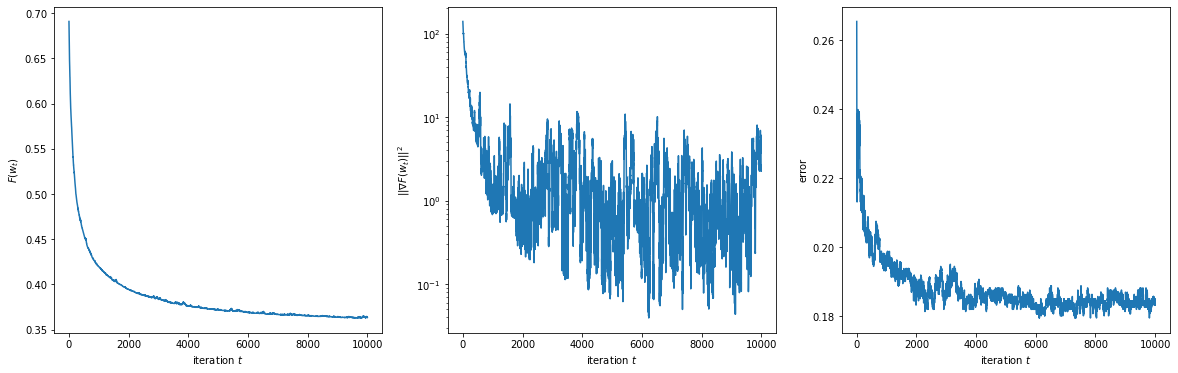

In [26]:
%%time
print("Run SGD on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling")
_, data = SGD(X_bad,y,BS=10,gamma=0.02*np.diagonal(XTX_bad+1e-10)**-0.5)
plot_data(data)

### SARAH

Run SARAH on corrupted data
CPU times: user 14.5 s, sys: 39.9 ms, total: 14.6 s
Wall time: 14.5 s


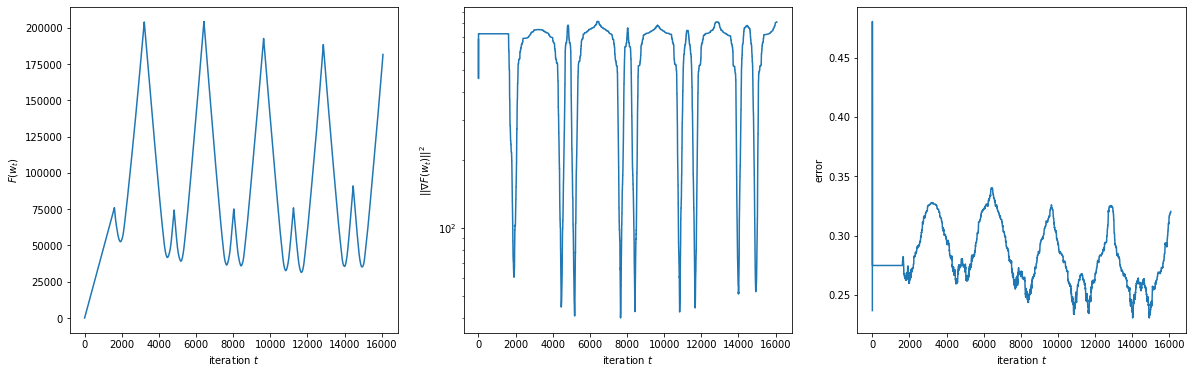

In [27]:
%%time
print("Run SARAH on corrupted data")
_, data = SARAH(X_bad,y,gamma=0.2)
plot_data(data)

Run SARAH on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling
CPU times: user 14.2 s, sys: 34.6 ms, total: 14.2 s
Wall time: 14.3 s


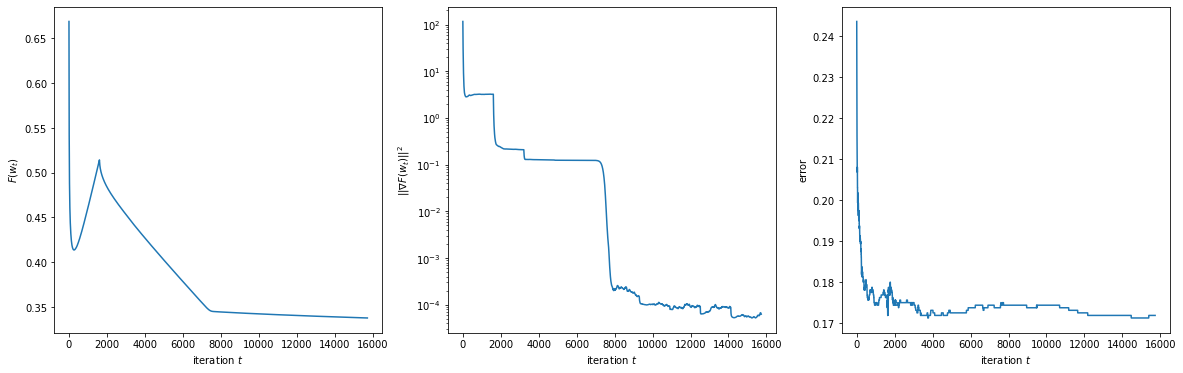

In [28]:
%%time
print("Run SARAH on corrupted data with diag(X_bad^TX_bad)^-0.5 scaling")
_, data = SARAH(X_bad,y,BS=10,gamma=0.2*np.diagonal(XTX_bad+1e-10)**-0.5)
plot_data(data)

## SGD and SARAH with Hessian scaling

In [29]:
def SGD_Hessian(X, y, gamma=0.02, BS=1, T=10000, seed=SEED,
                lam=0.0, full_hessian=False):
  np.random.seed(seed+1)
  data = []
  w = np.zeros(X.shape[1])
  for it in range(T):
    i = np.random.choice(X.shape[0], BS)
    # hessian
    g = grad(X,y,w,i) + lam * np.linalg.norm(w)
    iH = None if full_hessian else i
    H = hessian(X,y,w,iH) + lam * np.eye(w.shape[0]) # full Hessian
    w = w - gamma * np.diagonal(H+1e-10)**-1 * g
    ##
    data.append((F(X,y,w) + 0.5*lam*np.linalg.norm(w)**2,
                  np.linalg.norm(grad(X,y,w))**2,
                  np.mean(X.dot(w)*y < 0)))
  return w, np.array(data)


def SARAH_Hessian(X, y, gamma=0.2, BS=1, epochs=10, seed=SEED,
                  lam=0.0, full_hessian=False):
  np.random.seed(seed+1)
  data = []
  wn = np.zeros(X.shape[1])
  for ep in range(epochs):
    v = grad(X,y,wn)
    nv0 = np.linalg.norm(v)
    wp = wn[:]
    for it in range(10**10):
      i = np.random.choice(X.shape[0], BS)
      gn = grad(X,y,wn,i) + lam * np.linalg.norm(wn)
      gp = grad(X,y,wp,i) + lam * np.linalg.norm(wn)
      v += gn - gp
      wp = wn[:]
      # hessian
      iH = None if full_hessian else i
      H = hessian(X,y,wn,iH) + lam * np.eye(wn.shape[0])
      wn = wn - gamma * np.diagonal(H+1e-10)**-1 * v
      data.append((F(X,y,wn) + 0.5*lam*np.linalg.norm(wn)**2,
                   np.linalg.norm(grad(X,y,wn))**2,
                   np.mean(X.dot(wn)*y < 0)))
      nv = np.linalg.norm(v)
      if nv < 0.1*nv0 or it > X.shape[0]:
        break
        
  return wn, np.array(data)

Run SGD-Hessian on corrupted data
CPU times: user 9.85 s, sys: 24.9 ms, total: 9.87 s
Wall time: 9.86 s


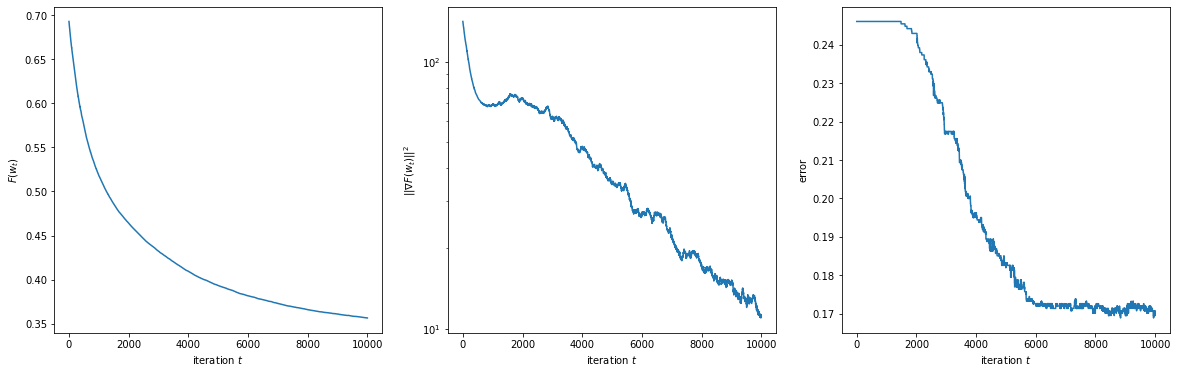

In [30]:
%%time
print("Run SGD-Hessian on corrupted data")
_, data = SGD_Hessian(X_bad,y,BS=10,gamma=1e-4)
plot_data(data)

Run SGD-Hessian with hessian of full dataset
CPU times: user 52.2 s, sys: 21.1 s, total: 1min 13s
Wall time: 37.3 s


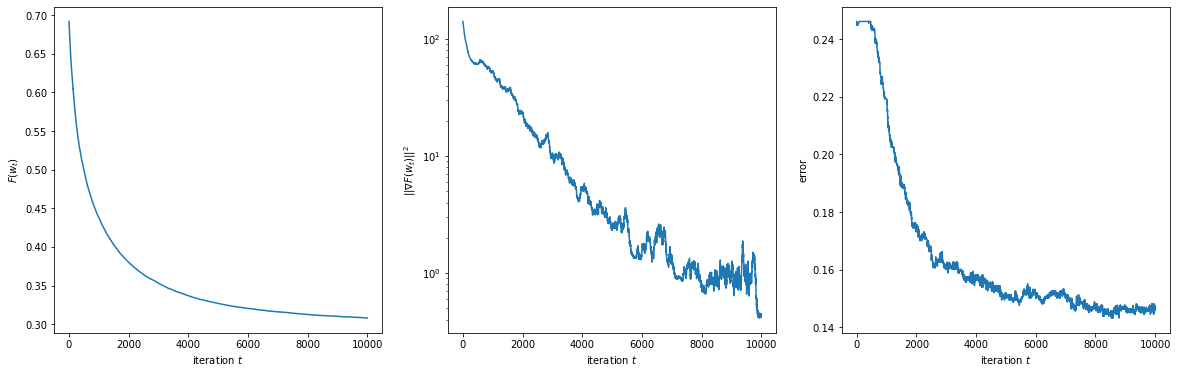

In [41]:
%%time
print("Run SGD-Hessian with hessian of full dataset")
_, data = SGD_Hessian(X_bad,y,BS=10,gamma=2e-4,full_hessian=True)
plot_data(data)

Run SARAH-Hessian
CPU times: user 38.8 s, sys: 156 ms, total: 39 s
Wall time: 38.9 s


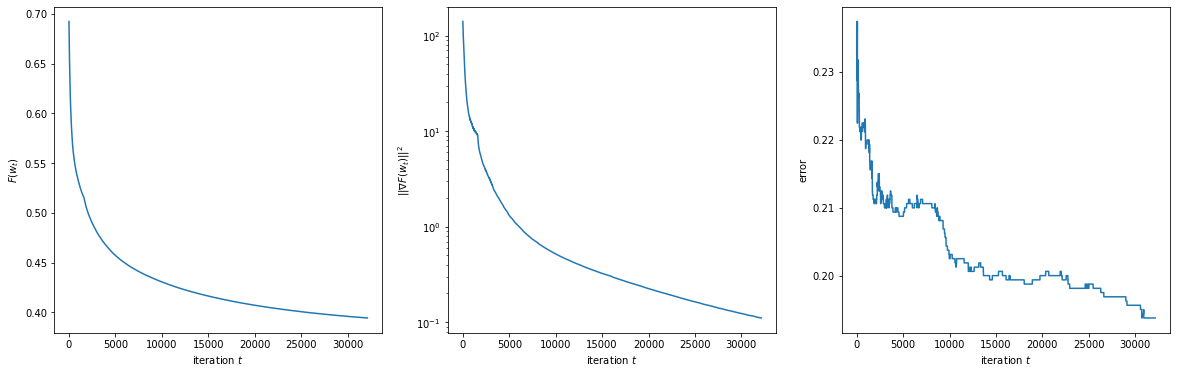

In [31]:
%%time
print("Run SARAH-Hessian")
_, data = SARAH_Hessian(X_bad,y,gamma=1e-15,epochs=20)
plot_data(data)

Run SARAH-Hessian with regularization
CPU times: user 37.2 s, sys: 113 ms, total: 37.3 s
Wall time: 37.2 s


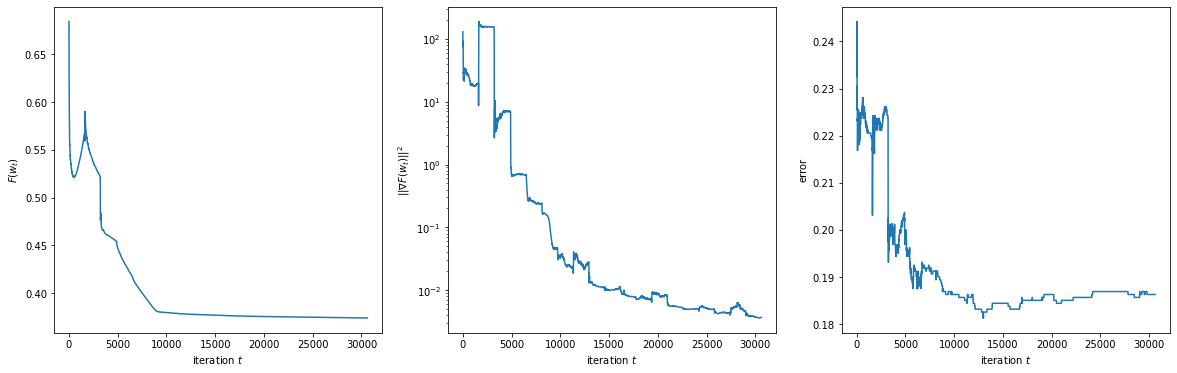

In [32]:
%%time
print("Run SARAH-Hessian with regularization")
_, data = SARAH_Hessian(X_bad,y,gamma=1e-5,epochs=20,lam=0.1)
plot_data(data)

Run SARAH-Hessian with hessian of full dataset
CPU times: user 2min 58s, sys: 1min 14s, total: 4min 12s
Wall time: 2min 8s


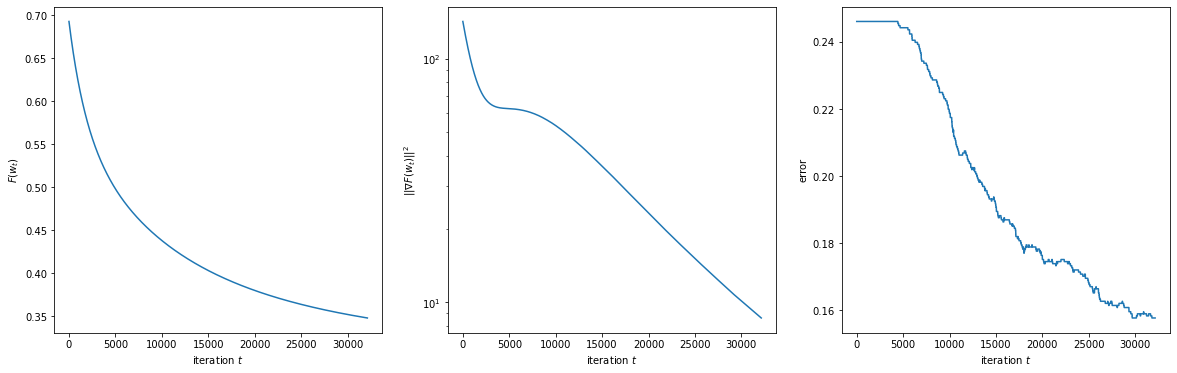

In [33]:
%%time
print("Run SARAH-Hessian with hessian of full dataset")
_, data = SARAH_Hessian(X_bad,y,gamma=2e-5,epochs=20,lam=0.,full_hessian=True)
plot_data(data)

Run SARAH-Hessian with regularization and hessian of full dataset
CPU times: user 3min 2s, sys: 1min 17s, total: 4min 20s
Wall time: 2min 12s


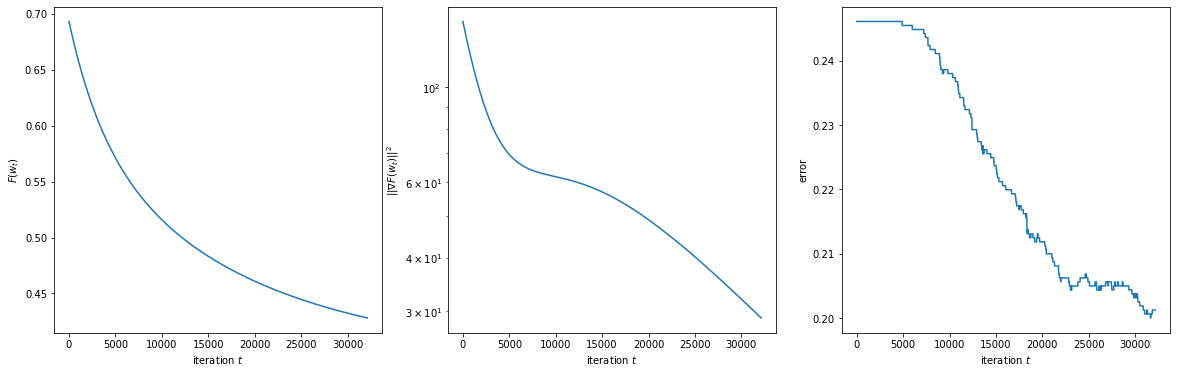

In [42]:
%%time
print("Run SARAH-Hessian with regularization and hessian of full dataset")
_, data = SARAH_Hessian(X_bad,y,gamma=2e-5,epochs=20,lam=0.1,full_hessian=True)
plot_data(data)

## OASIS + SARAH with adaptive Hessian scaling

In [168]:
def sample_z(size):
  return 2 * np.random.randint(0,2,size) - 1

def norm_scaled(x,D):
  return np.sqrt(np.sum(x * D * x))

def OASIS(X, y, gamma=1.0, beta=0.99, alpha=1e-5, theta=1e10,
          BS=1, T=10000, seed=SEED):
  np.random.seed(seed+1)
  data = []
  w = np.zeros(X.shape[1])
  D = np.ones_like(w)
  #D = hessian(X,y,w)
  # first step
  i = np.random.choice(X.shape[0], BS)
  g = grad(X,y,w,i)
  w_prev = w[:]
  w = w - gamma * D**-1 * g
  for it in range(T):
    i = np.random.choice(X.shape[0], BS)
    # estimate hessian diagonal
    z = sample_z(w.shape)
    #D_est = z * hvp(X,y,w,z,i)
    D_est = z * (grad(X,y,w+z,i) - grad(X,y,w,i))
    D = np.abs(beta * D + (1-beta) * D_est)
    D[D < alpha] = alpha
    # Calculate gradients
    g_prev = grad(X,y,w_prev,i)
    g = grad(X,y,w,i)
    # adaptive learning rate
    """
    gamma_prev = gamma
    gamma_est = 0.5 * norm_scaled(w-w_prev,D) / norm_scaled(g-g_prev,D)
    gamma = np.minimum(gamma * np.sqrt(1 + theta), gamma_est)
    theta = gamma / gamma_prev
    """
    # update
    w_prev = w[:]
    w = w - gamma * D**-1 * g
    data.append((F(X,y,w),
                  np.linalg.norm(grad(X,y,w))**2,
                  np.mean(X.dot(w)*y < 0),))
  return w, np.array(data)


def SARAH_AdaHessian(X, y, gamma=0.2, beta=0.99, alpha=1e-5,
                     BS=1, epochs=10, seed=SEED, lam=0.0):
  np.random.seed(seed+1)
  data = []
  wn = np.zeros(X.shape[1])
  D = np.ones_like(wn)
  for ep in range(epochs):
    v = grad(X,y,wn)
    nv0 = np.linalg.norm(v)
    wp = wn[:]
    for it in range(10**10):
      i = np.random.choice(X.shape[0], BS)
      gn = grad(X,y,wn,i) + lam * np.linalg.norm(wn)
      gp = grad(X,y,wp,i) + lam * np.linalg.norm(wn)
      v += gn - gp
      wp = wn[:]
      # estimate hessian diagonal
      z = sample_z(wn.shape)
      #D_est = z * hvp(X,y,wn,z,i)
      D_est = z * (grad(X,y,wn+z,i) - grad(X,y,wn,i))
      D = np.abs(beta * D + (1-beta) * D_est)
      D[D < alpha] = alpha
      # update rule
      wn = wn - gamma * D**-1 * v
      data.append((F(X,y,wn) + 0.5*lam*np.linalg.norm(wn)**2,
                   np.linalg.norm(grad(X,y,wn))**2,
                   np.mean(X.dot(wn)*y < 0)))
      nv = np.linalg.norm(v)
      if nv < 0.1*nv0 or it > X.shape[0]:
        break
        
  return wn, np.array(data)

Run OASIS
CPU times: user 14.3 s, sys: 65.5 ms, total: 14.4 s
Wall time: 14.3 s


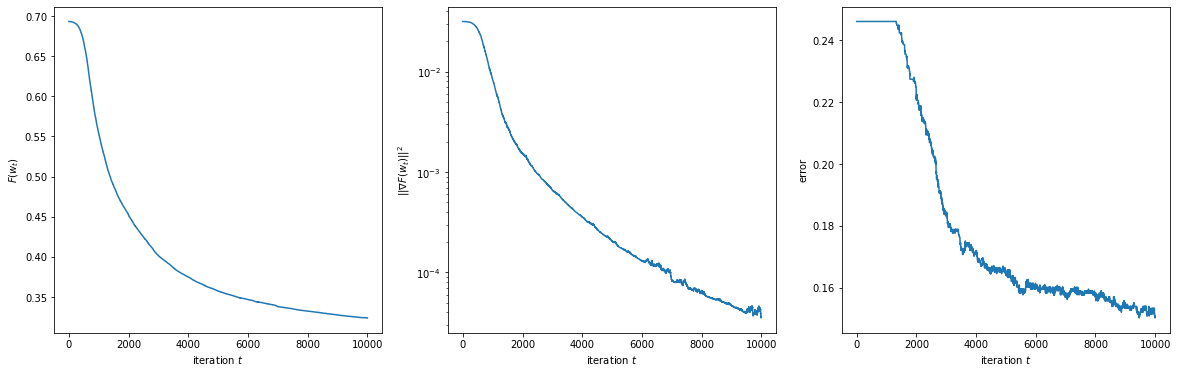

In [169]:
%%time
print("Run OASIS")
_, data = OASIS(X,y,BS=10,gamma=1e-4,beta=0.99)
plot_data(data)

Run OASIS on corrupted data
CPU times: user 14.3 s, sys: 59.8 ms, total: 14.4 s
Wall time: 14.3 s


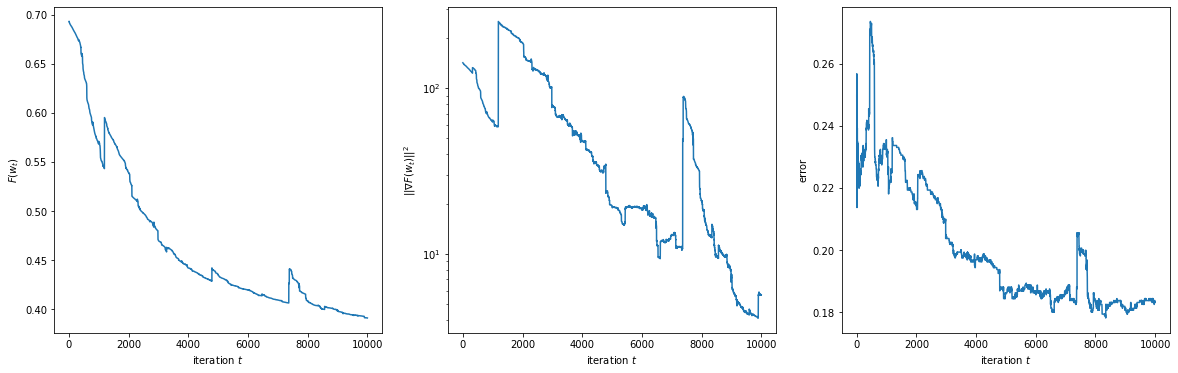

In [170]:
%%time
print("Run OASIS on corrupted data")
_, data = OASIS(X_bad,y,BS=10,gamma=1e-6,beta=0.99)
plot_data(data)

Run SARAH-AdaHessian
CPU times: user 23.8 s, sys: 99.5 ms, total: 23.9 s
Wall time: 23.9 s


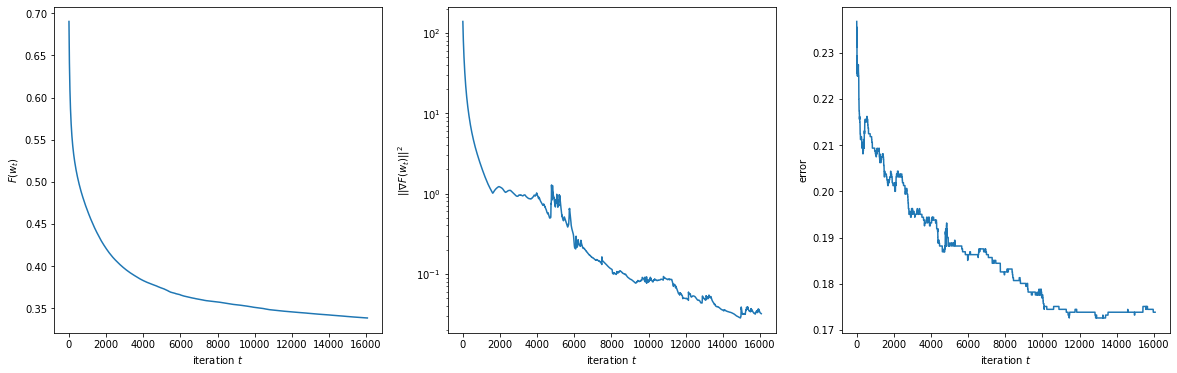

In [181]:
%%time
print("Run SARAH-AdaHessian")
_, data = SARAH_AdaHessian(X_bad,y,BS=10,gamma=2e-5,beta=0.999)
plot_data(data)